In [33]:
import pandas as pd
from pandas import Series

import numpy as np
from math import sqrt
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
import datetime as dt

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from scipy.stats import boxcox

import warnings

%matplotlib inline

rcParams['figure.figsize'] = 15, 6

In [22]:
# Read house price index data
dateparse = lambda dates: pd.to_datetime(dates)
hpi_df = pd.read_csv('hpi.csv', parse_dates=['DATE'], index_col='DATE',date_parser=dateparse)
hpi_df.head()

,index
DATE,
1987-01-01,70.266973
1987-02-01,70.640678
1987-03-01,71.046774
1987-04-01,71.411571
1987-05-01,71.882711


In [3]:
hpi_df.tail()

,index
DATE,
2018-03-01,211.562880
2018-04-01,213.115672
2018-05-01,213.530971
2018-06-01,214.250824
2018-07-01,213.806362


In [4]:
hpi_df.dtypes

index    float64
dtype: object

In [5]:
hpi_df.index

DatetimeIndex(['1987-01-01', '1987-02-01', '1987-03-01', '1987-04-01',
               '1987-05-01', '1987-06-01', '1987-07-01', '1987-08-01',
               '1987-09-01', '1987-10-01',
               ...
               '2017-10-01', '2017-11-01', '2017-12-01', '2018-01-01',
               '2018-02-01', '2018-03-01', '2018-04-01', '2018-05-01',
               '2018-06-01', '2018-07-01'],
              dtype='datetime64[ns]', name='DATE', length=379, freq=None)

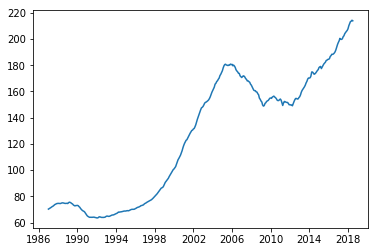

In [6]:
plt.plot(hpi_df)

In [23]:
# This final year of data will be used to validate the final model.
series = Series.from_csv('hpi.csv', header=0)
split_point = len(series) - 12

# Separate dataset into 2 sets
dataset, validation = series[0:split_point], series[split_point:]

dataset.to_csv('dataset.csv')
validation.to_csv('validation.csv')

/Users/tara/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:3724: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  infer_datetime_format=infer_datetime_format)


In [24]:
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]

In [25]:
# Establish a baseline of performance.
# walk-forward validation 
# and print the prediction and observation for each iteration of the test dataset.
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    # predict
    yhat = history[-1]
    predictions.append(yhat)
    # observation
    obs = test[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
# report performance
mse = mean_squared_error(test, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)

# The persistence model achieved an RMSE of 1.090. 
# This means that on average, the model was wrong by about 1.090 for each prediction made.

>Predicted=144.203, Expected=146
>Predicted=145.849, Expected=147
>Predicted=147.410, Expected=148
>Predicted=147.858, Expected=149
>Predicted=148.525, Expected=150
>Predicted=149.698, Expected=151
>Predicted=150.973, Expected=152
>Predicted=151.641, Expected=152
>Predicted=151.879, Expected=152
>Predicted=152.378, Expected=153
>Predicted=152.892, Expected=154
>Predicted=153.565, Expected=155
>Predicted=154.607, Expected=156
>Predicted=155.904, Expected=158
>Predicted=157.683, Expected=159
>Predicted=159.303, Expected=161
>Predicted=160.573, Expected=162
>Predicted=161.987, Expected=163
>Predicted=163.253, Expected=166
>Predicted=165.531, Expected=166
>Predicted=166.174, Expected=168
>Predicted=167.516, Expected=168
>Predicted=168.141, Expected=169
>Predicted=169.289, Expected=170
>Predicted=170.159, Expected=172
>Predicted=172.052, Expected=173
>Predicted=173.053, Expected=174
>Predicted=174.318, Expected=176
>Predicted=175.759, Expected=178
>Predicted=177.935, Expected=179
>Predicted

In [26]:
series = Series.from_csv('dataset.csv')
print(series.describe())

count    367.000000
mean     123.025476
std       46.244717
min       63.559357
25%       73.129853
50%      134.527652
75%      165.158450
max      201.640855
dtype: float64


/Users/tara/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:3724: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  infer_datetime_format=infer_datetime_format)


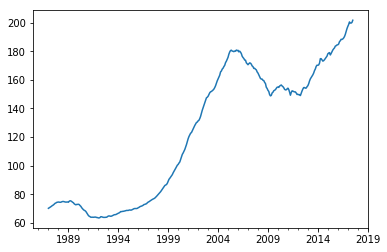

In [11]:
series.plot()
plt.show()

# There may be an increasing trend of index over time.

ADF Statistic: -1.811684
p-value: 0.374676
Critical Values:
	1%: -3.450
	5%: -2.870
	10%: -2.571


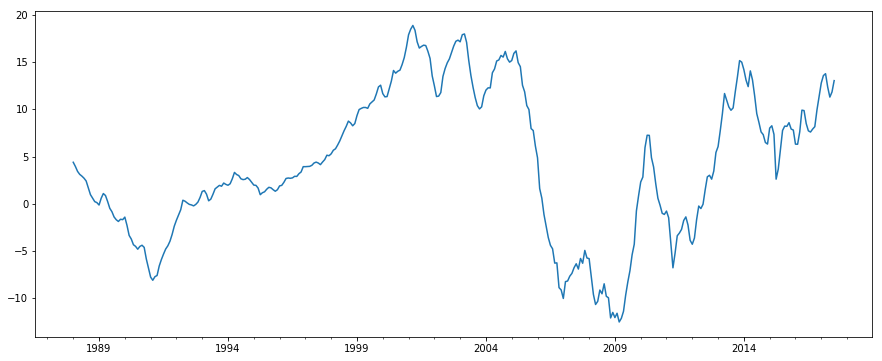

In [27]:
# make it stationary this by first differencing the series 
# and using a statistical test to confirm that the result is stationary.
#
# creates a deseasonalized version of the series and saves it to file stationary.csv
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

X = series.values
X = X.astype('float32')
# difference data
months_in_year = 12
stationary = difference(X, months_in_year)
stationary.index = series.index[months_in_year:]
# check if stationary
result = adfuller(stationary)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
# save
stationary.to_csv('stationary.csv')
# plot
stationary.plot()
plt.show()

/Users/tara/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:3724: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  infer_datetime_format=infer_datetime_format)
/Users/tara/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


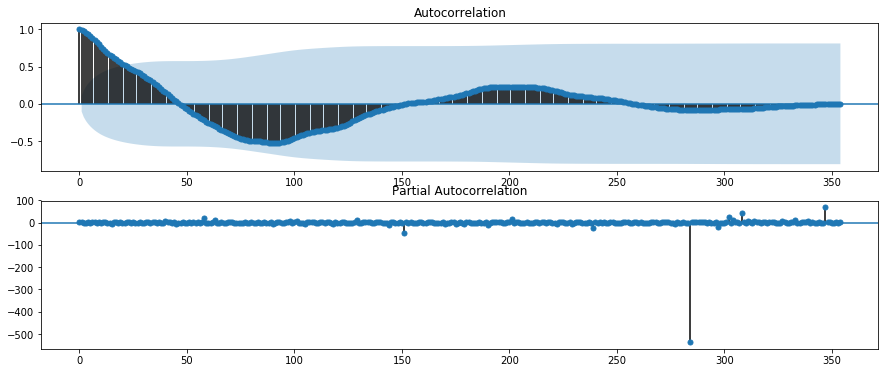

In [28]:
# Select the lag values for the Autoregression (AR) and Moving Average (MA) parameters, p and q respectively.
# by reviewing Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots.

series = Series.from_csv('stationary.csv')
plt.figure()
plt.subplot(211)
plot_acf(series, ax=plt.gca())
plt.subplot(212)
plot_pacf(series, ax=plt.gca())
plt.show()

In [62]:
# Start from usering ARIMA(1,0,1)
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return diff

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

# load data
series = Series.from_csv('dataset.csv')
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    # difference data
    months_in_year = 12
    diff = difference(history, months_in_year)
    # predict
    model = ARIMA(diff, order=(1,1,1))
    model_fit = model.fit(trend='nc', disp=0)
    yhat = model_fit.forecast()[0]
    yhat = inverse_difference(history, yhat, months_in_year)
    predictions.append(yhat)
    # observation
    obs = test[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
# report performance
mse = mean_squared_error(test, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)

# RMSE is a bit higher than the persistence RMSE of 1.09

>Predicted=134.251, Expected=135
>Predicted=135.214, Expected=137
>Predicted=139.123, Expected=139
>Predicted=140.390, Expected=141
>Predicted=142.258, Expected=142
>Predicted=143.769, Expected=144
>Predicted=145.645, Expected=146
>Predicted=147.313, Expected=147
>Predicted=148.057, Expected=148
>Predicted=148.758, Expected=149
>Predicted=148.817, Expected=150
>Predicted=151.420, Expected=151
>Predicted=152.547, Expected=152
>Predicted=153.185, Expected=152
>Predicted=152.670, Expected=152
>Predicted=153.144, Expected=153
>Predicted=153.850, Expected=154
>Predicted=154.741, Expected=155
>Predicted=155.698, Expected=156
>Predicted=157.265, Expected=158
>Predicted=158.314, Expected=159
>Predicted=160.819, Expected=161
>Predicted=162.092, Expected=162
>Predicted=163.399, Expected=163
>Predicted=163.899, Expected=166
>Predicted=166.952, Expected=166
>Predicted=166.853, Expected=168
>Predicted=168.602, Expected=168
>Predicted=168.853, Expected=169
>Predicted=170.656, Expected=170
>Predicted

In [ ]:
# Grid Search ARIMA Hyperparameters to find a better configuration
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return numpy.array(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    X = X.astype('float32')
    train_size = int(len(X) * 0.50)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        # difference data
        months_in_year = 12
        diff = difference(history, months_in_year)
        model = ARIMA(diff, order=arima_order)
        model_fit = model.fit(trend='nc', disp=0)
        yhat = model_fit.forecast()[0]
        yhat = inverse_difference(history, yhat, months_in_year)
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    mse = mean_squared_error(test, predictions)
    rmse = sqrt(mse)
    return rmse

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s RMSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

# load dataset
series = Series.from_csv('dataset.csv')
# evaluate parameters
p_values = range(0, 7)
d_values = range(0, 3)
q_values = range(0, 7)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

# ARIMA(1, 1, 4) Gives the lowest RMSE=0.994

ARIMA(0, 1, 1) RMSE=1.168
ARIMA(0, 1, 2) RMSE=1.060
ARIMA(0, 1, 3) RMSE=0.995
ARIMA(0, 2, 1) RMSE=1.220
ARIMA(0, 2, 2) RMSE=1.188
ARIMA(0, 2, 3) RMSE=1.071
ARIMA(1, 1, 0) RMSE=1.127
ARIMA(1, 1, 1) RMSE=1.132
ARIMA(1, 1, 3) RMSE=1.023
ARIMA(1, 1, 4) RMSE=0.994
ARIMA(1, 1, 5) RMSE=1.004
ARIMA(1, 1, 6) RMSE=1.046
ARIMA(1, 2, 0) RMSE=1.252
ARIMA(1, 2, 1) RMSE=1.228
ARIMA(1, 2, 2) RMSE=1.253
ARIMA(1, 2, 3) RMSE=1.022
ARIMA(2, 1, 0) RMSE=1.133
ARIMA(2, 1, 1) RMSE=1.110
ARIMA(2, 1, 2) RMSE=1.004
ARIMA(2, 1, 3) RMSE=1.011
ARIMA(2, 1, 4) RMSE=1.008
ARIMA(2, 1, 5) RMSE=1.013
ARIMA(2, 2, 0) RMSE=1.262
ARIMA(2, 2, 1) RMSE=1.231
ARIMA(2, 2, 2) RMSE=1.112


/Users/tara/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:3724: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  infer_datetime_format=infer_datetime_format)


                0
count  184.000000
mean     0.007215
std      0.996773
min     -3.046719
25%     -0.627339
50%     -0.028303
75%      0.598949
max      3.078867


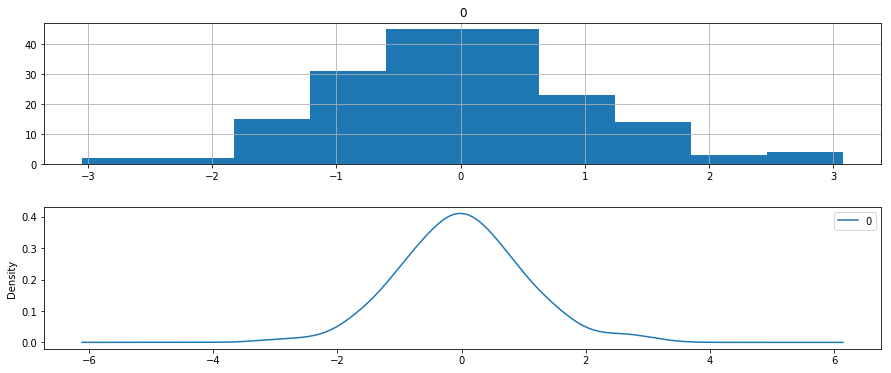

In [32]:
# Review residual forecast errors
# Ideally, the distribution of residual errors should be a Gaussian with a zero mean.
# Mean is closed to zero

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return diff

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

# load data
series = Series.from_csv('dataset.csv')
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    # difference data
    months_in_year = 12
    diff = difference(history, months_in_year)
    # predict
    model = ARIMA(diff, order=(1, 1, 4))
    model_fit = model.fit(trend='nc', disp=0)
    yhat = model_fit.forecast()[0]
    yhat = inverse_difference(history, yhat, months_in_year)
    predictions.append(yhat)
    # observation
    obs = test[i]
    history.append(obs)
# errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = pd.DataFrame(residuals)
print(residuals.describe())
# plot
plt.figure()
plt.subplot(211)
residuals.hist(ax=plt.gca())
plt.subplot(212)
residuals.plot(kind='kde', ax=plt.gca())
plt.show()

In [34]:
# Finalizing the model involves fitting an ARIMA model on the entire dataset, 
# on a transformed version of the entire dataset.
# Once fit, the model can be saved to file for later use.

# monkey patch around bug in ARIMA class
def __getnewargs__(self):
    return ((self.endog),(self.k_lags, self.k_diff, self.k_ma))

ARIMA.__getnewargs__ = __getnewargs__

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return diff

# load data
series = Series.from_csv('dataset.csv')
# prepare data
X = series.values
X = X.astype('float32')
# difference data
months_in_year = 12
diff = difference(X, months_in_year)
# fit model
model = ARIMA(diff, order=(1, 1, 4))
model_fit = model.fit(trend='nc', disp=0)

# save model
# ARIMAResult object includes the coefficients and all other internal data returned when fitting the model.
model_fit.save('model.pkl')

/Users/tara/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:3724: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  infer_datetime_format=infer_datetime_format)


In [35]:
# Make prediction

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

series = Series.from_csv('dataset.csv')
months_in_year = 12
model_fit = ARIMAResults.load('model.pkl')
yhat = float(model_fit.forecast()[0])
yhat = inverse_difference(series.values, yhat, months_in_year)
print('Predicted: %.3f' % yhat)

/Users/tara/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:3724: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  infer_datetime_format=infer_datetime_format)


Predicted: 202.696


/Users/tara/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:3724: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  infer_datetime_format=infer_datetime_format)


>Predicted=202.696, Expected=202.429
>Predicted=203.067, Expected=204.035
>Predicted=206.005, Expected=204.891
>Predicted=206.868, Expected=205.760
>Predicted=206.352, Expected=206.461
>Predicted=207.992, Expected=207.746
>Predicted=209.140, Expected=210.032
>Predicted=212.027, Expected=211.563
>Predicted=210.830, Expected=213.116
>Predicted=213.849, Expected=213.531
>Predicted=214.981, Expected=214.251
>Predicted=214.651, Expected=213.806
RMSE: 0.963


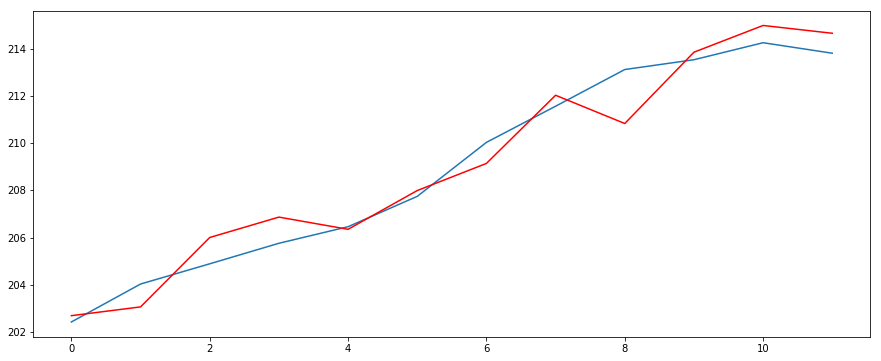

In [36]:
# Validate model
# Load validation.csv file and use to see how well the model really is on “unseen” data.
# Load the model and use it in a rolling-forecast manner, updating the transform and model for each time step. 

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return diff

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

# load and prepare datasets
dataset = Series.from_csv('dataset.csv')
X = dataset.values.astype('float32')
history = [x for x in X]
months_in_year = 12
validation = Series.from_csv('validation.csv')
y = validation.values.astype('float32')

# load model
model_fit = ARIMAResults.load('model.pkl')

# make first prediction
predictions = list()
yhat = float(model_fit.forecast()[0])
yhat = inverse_difference(history, yhat, months_in_year)
predictions.append(yhat)
history.append(y[0])
print('>Predicted=%.3f, Expected=%.3f' % (yhat, y[0]))

# rolling forecasts
for i in range(1, len(y)):
    # difference data
    months_in_year = 12
    diff = difference(history, months_in_year)
    # predict
    model = ARIMA(diff, order=(1, 1, 4))
    model_fit = model.fit(trend='nc', disp=0)
    yhat = model_fit.forecast()[0]
    yhat = inverse_difference(history, yhat, months_in_year)
    predictions.append(yhat)
    # observation
    obs = y[i]

    history.append(obs)
    print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
    
# report performance
mse = mean_squared_error(y, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)

plt.plot(y)
plt.plot(predictions, color='red')
plt.show()

# save final model
model_fit.save('final_model.pkl')

In [37]:
# multi-step forecast

series = Series.from_csv('dataset.csv', header=None)

# seasonal difference
X = series.values

months_in_year = 12
differenced = difference(X, months_in_year)
# fit model
model = ARIMA(differenced, order=(1, 1, 4))
model_fit = model.fit(trend='nc', disp=0)

# multi-step out-of-sample forecast
forecast = model_fit.forecast(steps=3)[0]

# invert the differenced forecast to something usable
history = [x for x in X]
month = 1

for yhat in forecast:
    inverted = inverse_difference(history, yhat, months_in_year)
    print('Month %d: %f' % (month, inverted))
    history.append(inverted)
    month += 1

/Users/tara/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:3724: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  infer_datetime_format=infer_datetime_format)


Month 1: 202.695690
Month 2: 203.493640
Month 3: 204.868765
